In [12]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
import numpy as np
from qiskit.quantum_info import Statevector
from math import log
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [13]:
X, y = make_blobs(n_samples=1000, centers=2, n_features=4, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(800, 4) (200, 4) (800,) (200,)


In [16]:
x1_train = [X_train[i] for i in range(len(X_train)) if y_train[i] == 0]
x2_train = [X_train[i] for i in range(len(X_train)) if y_train[i] == 1]

x1_train = np.array(x1_train)
x2_train = np.array(x2_train)

x1_test = [X_test[i] for i in range(len(X_test)) if y_test[i] == 0]
x2_test = [X_test[i] for i in range(len(X_test)) if y_test[i] == 1]

x1_test = np.array(x1_test)
x2_test = np.array(x2_test)

In [17]:
training_size = 400
# dimension of data sets
n = 4
training_input = {'A':x1_train, 'B':x2_train}
test_input = {'A':x1_test, 'B':x2_test}
class_labels = ['A', 'B']
sv = Statevector.from_label('0' * n)

In [18]:
def final_circuit(circuit, data, params):
    for i in range(n):
        circuit.h(i)
        circuit.rz(data[i],i)
        circuit.ry(params[i], i)
    circuit.cx(0,3)
    circuit.cx(1,2)
    circuit.barrier()
    for i in range(n):
        circuit.rz(data[i],i)
        circuit.ry(params[i+4], i)

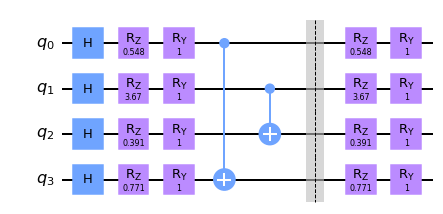

In [19]:
cir = QuantumCircuit(4)
final_circuit(cir, x1_train[0],[1,1,1,1,1,1,1,1])
cir.draw('mpl')

In [20]:
from typing import Optional, Callable, Tuple, List
import os
import numpy as np
import csv
from qiskit.aqua import aqua_globals
from qiskit.aqua.components.optimizers import Optimizer, OptimizerSupportLevel


class ADAM(Optimizer):
    """Adam and AMSGRAD optimizers.
        This implementation is taken directly from Qiskit. Please see Qiskit optimiser documentation for details.
        """

    _OPTIONS = ['maxiter', 'tol', 'lr', 'beta_1', 'beta_2',
                'noise_factor', 'eps', 'amsgrad', 'snapshot_dir']

    def __init__(self,
                 maxiter: int = 10000,
                 tol: float = 1e-6,
                 lr: float = 1e-3,
                 beta_1: float = 0.9,
                 beta_2: float = 0.99,
                 noise_factor: float = 1e-8,
                 eps: float = 1e-10,
                 amsgrad: bool = False,
                 snapshot_dir: Optional[str] = None) -> None:

        super().__init__()
        for k, v in locals().items():
            if k in self._OPTIONS:
                self._options[k] = v
        self._maxiter = maxiter
        self._snapshot_dir = snapshot_dir
        self._tol = tol
        self._lr = lr
        self._beta_1 = beta_1
        self._beta_2 = beta_2
        self._noise_factor = noise_factor
        self._eps = eps
        self._amsgrad = amsgrad
        self.loss_list = []
        self.params = []
        # runtime variables
        self._t = 0  # time steps
        self._m = np.zeros(1)
        self._v = np.zeros(1)
        if self._amsgrad:
            self._v_eff = np.zeros(1)

        if self._snapshot_dir:

            with open(os.path.join(self._snapshot_dir, 'adam_params.csv'), mode='w') as csv_file:
                if self._amsgrad:
                    fieldnames = ['v', 'v_eff', 'm', 't']
                else:
                    fieldnames = ['v', 'm', 't']
                writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
                writer.writeheader()

    def get_support_level(self):
        """ Return support level dictionary """
        return {
            'gradient': OptimizerSupportLevel.supported,
            'bounds': OptimizerSupportLevel.ignored,
            'initial_point': OptimizerSupportLevel.supported
        }

    def save_params(self, snapshot_dir: str) -> None:
        if self._amsgrad:
            with open(os.path.join(snapshot_dir, 'adam_params.csv'), mode='a') as csv_file:
                fieldnames = ['v', 'v_eff', 'm', 't']
                writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
                writer.writerow({'v': self._v, 'v_eff': self._v_eff,
                                 'm': self._m, 't': self._t})
        else:
            with open(os.path.join(snapshot_dir, 'adam_params.csv'), mode='a') as csv_file:
                fieldnames = ['v', 'm', 't']
                writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
                writer.writerow({'v': self._v, 'm': self._m, 't': self._t})

    def load_params(self, load_dir: str) -> None:

        with open(os.path.join(load_dir, 'adam_params.csv'), mode='r') as csv_file:
            if self._amsgrad:
                fieldnames = ['v', 'v_eff', 'm', 't']
            else:
                fieldnames = ['v', 'm', 't']
            reader = csv.DictReader(csv_file, fieldnames=fieldnames)
            for line in reader:
                v = line['v']
                if self._amsgrad:
                    v_eff = line['v_eff']
                m = line['m']
                t = line['t']

        v = v[1:-1]
        self._v = np.fromstring(v, dtype=float, sep=' ')
        if self._amsgrad:
            v_eff = v_eff[1:-1]
            self._v_eff = np.fromstring(v_eff, dtype=float, sep=' ')
        m = m[1:-1]
        self._m = np.fromstring(m, dtype=float, sep=' ')
        t = t[1:-1]
        self._t = np.fromstring(t, dtype=int, sep=' ')

    def minimize(self, objective_function: Callable[[np.ndarray], float], initial_point: np.ndarray,
                 gradient_function: Callable[[np.ndarray], float]) -> Tuple[np.ndarray, float, int]:

        derivative = gradient_function(initial_point)
        self._t = 0
        self._m = np.zeros(np.shape(derivative))
        self._v = np.zeros(np.shape(derivative))
        if self._amsgrad:
            self._v_eff = np.zeros(np.shape(derivative))
        self.loss_list = []
        self.params = []
        params = params_new = initial_point
        while self._t < self._maxiter:
            derivative = gradient_function(params)
            self._t += 1
            self._m = self._beta_1 * self._m + (1 - self._beta_1) * derivative
            self._v = self._beta_2 * self._v + (1 - self._beta_2) * derivative * derivative
            lr_eff = self._lr * np.sqrt(1 - self._beta_2 ** self._t) / (1 - self._beta_1 ** self._t)
            if not self._amsgrad:
                params_new = (params - lr_eff * self._m.flatten()
                              / (np.sqrt(self._v.flatten()) + self._noise_factor))
                self.params.append(params_new)
                self.loss_list.append(objective_function(params_new))
            else:
                self._v_eff = np.maximum(self._v_eff, self._v)
                params_new = (params - lr_eff * self._m.flatten()
                              / (np.sqrt(self._v_eff.flatten()) + self._noise_factor))
                self.params.append(params_new)
                self.loss_list.append(objective_function(params_new))
            if self._snapshot_dir:
                self.save_params(self._snapshot_dir)
            if np.linalg.norm(params - params_new) < self._tol:
                return params_new, objective_function(params_new), self._t
            else:
                params = params_new
        return params_new, objective_function(params_new), self._t

    def optimize(self, num_vars: int, objective_function: Callable[[np.ndarray], float],
                 gradient_function: Optional[Callable[[np.ndarray], float]] = None,
                 variable_bounds: Optional[List[Tuple[float, float]]] = None,
                 initial_point: Optional[np.ndarray] = None
                 ) -> Tuple[np.ndarray, float, int]:

        super().optimize(num_vars, objective_function, gradient_function,
                         variable_bounds, initial_point)
        if initial_point is None:
            initial_point = aqua_globals.random.random(num_vars)
        if gradient_function is None:
            gradient_function = Optimizer.wrap_function(Optimizer.gradient_num_diff,
                                                        (objective_function, self._eps))

        point, value, nfev = self.minimize(objective_function, initial_point, gradient_function)
        return point, value, nfev, self.loss_list, self.params

In [22]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
              class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circuit = QuantumCircuit(n)
        circ_ = final_circuit(circuit, x, params)
        qc = sv.evolve(circuit)
        qc_list += [qc]
    probs = []
    for qc in qc_list:
        counts = qc.probabilities_dict()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs


def CrossEntropy(yHat, y):
    if y == 'A':
      return -log(yHat['A'])
    else:
      return -log(1-yHat['A'])


def cost_function(training_input, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for label, samples in training_input.items():
        for sample in samples:
            training_labels += [label]
            training_samples += [sample]

    # classify all samples
    probs = classify(training_samples, params, class_labels)

    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += CrossEntropy(yHat=prob, y=training_labels[i])
    cost /= len(training_samples)
    #print(cost)
    # return objective value
    #print(cost)
    return cost


# setup the optimizer
optimizer = ADAM(maxiter=100, lr=0.1)

# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True)

d = 8  # num of trainable params
np.random.seed(0)
# randomly initialize the parameters
init_params = np.random.uniform(-1,1,d)
print(init_params)
opt_params, value, _, loss,params = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
print(loss)
print(opt_params)
# print results
f1 = 'quantum_loss_easy_layer1400q_%d.npy' %i
f2 = 'opt_params_easy_layer1400q_%d.npy'%i
np.save(f2, opt_params)
np.save(f1, loss)

[0.09762701 0.43037873 0.20552675 0.08976637]


IndexError: index 4 is out of bounds for axis 0 with size 4

In [38]:
def cost_function_test(training_input, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    i = 0
    for label, samples in test_input.items():
        for sample in samples:
            print(i)
            training_labels += [label]
            training_samples += [sample]
            i+=1

    # classify all samples
    probs = classify(training_samples, params, class_labels)

    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += CrossEntropy(yHat=prob, y=training_labels[i])
    cost /= len(training_samples)

    return cost

In [39]:
test_loss = []
for i in range(len(params)):
    test_loss.append(cost_function_test(test_input, class_labels, params[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


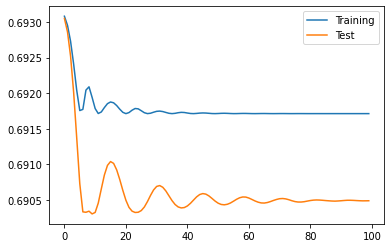

In [40]:
plt.plot(range(100), loss)
plt.plot(range(100), test_loss)

legendList = ['{}'.format(i) for i in ["Training", "Test","3 Layers","4 Layers"]]
plt.legend(legendList)

In [8]:
loss = np.zeros((100,100))
for i in range(100):
    file = 'Layer1Easy4q/quantum_loss_easy_layer14q_%d.npy'%i
    loss[i] += np.load(file, allow_pickle=True)

In [9]:
loss.shape

(100, 100)

Text(0.5, 1.0, 'Training - 1 Layer (Data Reuploading, Qubits = 4, Easy Model)')

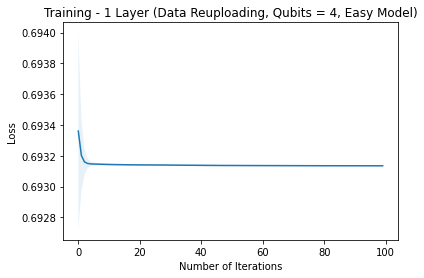

In [11]:
import matplotlib.pyplot as plt
groen = np.array([0,208,0])/255
stddevs =[]
averages =[]
sd = np.std(loss, axis=0)
av = np.average(loss, axis=0)
plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)
stddevs.append(sd)
averages.append(av)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training - 1 Layer (Data Reuploading, Qubits = 4, Easy Model)")